## This Is A Jupyter Notebook
It has a markdown starting section, that's quite neat!   
Let's try to create a Python code block next:

In [26]:
2 + 2

4

Alright, that seems to have gone well! Note how this second section is sandwiched in the middle of two code blocks.

The next code block uses `print` to send the output. The reason for this will be important later!

In [27]:
print("This is a message!")

This is a message!


## Thinking about Options
Let's take a moment and evaluate:
1. Hugo [Page Resources](https://gohugo.io/content-management/page-resources/) can be used to attach a resource to a post
2. A Jupyter Notebook is actually just a JSON file. 
3. Cursory googling shows people trying various options, including rendering:
    - [hugo_jupyter](https://pypi.org/project/hugo_jupyter/) - Turns "notebook" into it's own type of post. Frontmatter goes inside notebooks
    - [nb2hugo](https://github.com/vlunot/nb2hugo) - Similiar approach as above
    - [Hugo Blox](https://docs.hugoblox.com/tutorial/blog/step-4/) - Some custom themes take the same approach above
    - [Forum Topic discussing Jupyter Support](https://discourse.gohugo.io/t/ipython-notebook-support/3211)
    - [Skeptric on the nb2hugo workflow](https://skeptric.com/jupyter-hugo-blog/)

## Looking Inside Notebooks
Let's take a look inside **this** notebook itself. Since it's a JSON file, we can use `jq` and the `keys` function to start exploring:

In [28]:
!jq -M 'keys' simple.ipynb

[
  "cells",
  "metadata",
  "nbformat",
  "nbformat_minor"
]


Remember how I mentioned that the fact I used `print` will be relevant later? It's coming soon. I promise. Let's take a look at the first 4 cells of the notebook:

In [30]:
!jq -M '.cells[:4]' simple.ipynb

[
  {
    "attachments": {},
    "cell_type": "markdown",
    "metadata": {},
    "source": [
      "## This Is An Example Jupyter Notebook\n",
      "It has a markdown starting section, that's quite neat!   \n",
      "Let's try to create a Python code block next:"
    ]
  },
  {
    "cell_type": "code",
    "execution_count": 26,
    "metadata": {},
    "outputs": [
      {
        "data": {
          "text/plain": [
            "4"
          ]
        },
        "execution_count": 26,
        "metadata": {},
        "output_type": "execute_result"
      }
    ],
    "source": [
      "2 + 2"
    ]
  },
  {
    "attachments": {},
    "cell_type": "markdown",
    "metadata": {},
    "source": [
      "Alright, that seems to have gone well! Note how this second section is sandwiched in the middle of two code blocks.\n",
      "\n",
      "The next code block uses `print` to send the output. The reason for this will be important later!"
    ]
  },
  {
    "cell_type": "code",
    "execu

**Observations**   
- Every object has a `cell_type` which is either `markdown` or `code`
    - All cells have a `source`. Source is as array of strings containing the cell's source code line by line.
    - Cells which have been executed have an `outputs`
- While `outputs` is always an array, the contents differ:
    - When it's a normal Python evaluation, the `output_type` is `execution_result`.   
    In this case, we have to get the data from the `outputs[].data` which is a object containing keys corresponding to the mime type and value as an array containing the values.
    - When it's using `print`, the `output_type` is `stream`.   
    In this case, the `outputs[].text` is the array of strings we are interested in.

## But What About Images?
Fair point! We haven't encountered any in this notebook yet. Let's change that by copying in one of the [matplotlib examples](https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py):

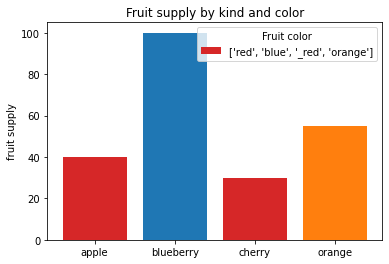

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['apple', 'blueberry', 'cherry', 'orange']
counts = [40, 100, 30, 55]
bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('fruit supply')
ax.set_title('Fruit supply by kind and color')
ax.legend(title='Fruit color')

plt.show()

Let's take a look inside this last cell:

In [48]:
!jq -M '.cells[-3].outputs[].data | keys' simple.ipynb

[
  "image/png",
  "text/plain"
]


Let's take a look at what's inside the image:

In [49]:
!jq -M '.cells[-3].outputs[].data["image/png"][:32]' simple.ipynb

"iVBORw0KGgoAAAANSUhEUgAAAYUAAAEI"


It's a base64 encoded png! That makes our life easier. 

Now, with all the observations so far, we now have enough information to create the shortcode

## The `ipynb` Shortcode
### Why a Shortcode?
Most of the previous approaches use layouts, but I have gone with a shortcode instead. Using this approach lets me keep the frontmatter in my post markdown file.

The main benefit of this is that I can have multiple notebooks inside a post if I want. 

### Copy Me! 
The below code goes in `layouts/shortcodes/ipynb.html`

    {{ $notebook := .Get 0 }}
    {{ range .Page.Resources.Match $notebook }} 
    <a href="{{.RelPermalink}}" download>🗒️ Download ({{ $notebook }})</a>
    {{ $content := .Content | transform.Unmarshal }}
    {{ $cells := $content.cells }}
    {{ range $cells }}
    <!-- For Markdown Cells -->
    {{ if eq .cell_type "markdown" }}
    {{ range .source }}{{ . | safeHTML }}{{ end }}
    {{ end }}

    <!-- For Code Cells -->
    {{ if eq .cell_type "code" }}
    ```python
    {{ range .source }}{{ . | safeHTML }}{{ end }}
    ```
    {{ if gt (len .outputs) 0 }}
    Output:
    {{ range .outputs }}
    {{ if .text }}
    ```
    {{ range .text }}{{ . | safeHTML}}{{ end }}
    ```
    {{ end }}
    {{ range $type, $data := .data }}
    {{ if strings.Contains $type "image" }}<img src="data:{{ $type }};base64,{{ $data | safeHTML }}">{{ end }}
    {{ if strings.Contains $type "text" }}
    ```
    {{ range $data }}{{ . | safeHTML }}{{ end }}
    ```
    {{ end }}{{ end }}{{ end }}{{ end }}{{ end }}{{ end }}{{ end }}
### How does it work?
This Hugo shortcode is designed to embed a Jupyter notebook into a Hugo website by parsing and displaying its content. It processes the Jupyter notebook content, separating Markdown and Code cells, rendering them accordingly on the Hugo page. It also handles outputs generated by code cells within the notebook.

Let's try to break down how it works:
- `{{ $notebook := .Get 0 }}`: This line gets the parameter passed to the shortcode.
- `{{ range .Page.Resources.Match $notebook }}`: This initiates a loop over the resources associated with the current page that match the provided notebook name.
- `<a href="{{.RelPermalink}}" download>🗒️ Download ({{ $notebook }})</a>`: This generates a download link for the notebook file. The `.RelPermalink` is the relative path to the notebook file.
- `{{ $content := .Content | transform.Unmarshal }}`: This extracts the content of the notebook and stores it in the `$content` variable.
- `{{ $cells := $content.cells }}`: This extracts the cells (sections) of the notebook and stores them in the `$cells` variable.
- `{{ if eq .cell_type "markdown" }}`: This checks if a cell is of type "markdown."
- `{{ range .source }}{{ . | safeHTML }}{{ end }}`: If the cell is a markdown type, it iterates through its content and renders it as HTML using `safeHTML`.
- `{{ if eq .cell_type "code" }}`: This checks if a cell is of type "code."
- ```python ... ```: This wraps code cells in a Python code block for display.
- `{{ range .source }}{{ . | safeHTML }}{{ end }}`: Renders the content of the code cell as HTML using `safeHTML`.
- `{{ if gt (len .outputs) 0 }}`: Checks if the code cell has any outputs.
- Renders outputs:
    - Text Outputs: Renders text outputs of the code cell.
    - Image Outputs: Renders image outputs encoded in base64 format.
    - Other Outputs: Handles other types of outputs (text or image) based on their data.

## Limitations and Closing Thoughts
- While the shortcode attempts to render Markdown and Code cells, it might not cover all possible cell types or formatting nuances within a Jupyter notebook. 
- Inline embedded images may be bad for performance as they aren't being lazy loaded
- This approach skips over a lot of the extra features which Jupyter notebooks have. I couldn't even tell you what they are because I don't know myself!
- While this is perfect for my workflow, and I'm excited by how much easier it makes for me to get more posts out by removing friction, I recognize that this shortcode/approach may not be for everyone. 
- There is [official documentation](https://ipython.org/ipython-doc/3/notebook/nbformat.html) for the .ipynb format, but I didn't really look at it. Someday in the future I might have to do that.

I hope you enjoyed reading this post. Have you experienced similiar things about the importance of removing friction in your workflow? Do you have any stories of things you automated to that end? [Tell me all about it!](mailto:hello@ishan.page)

***
> I've finally started a newsletter for those who wanted to receive updates over email.    
> You can subscribe below, or [check out the first issue here](/newsletters/00001-hello-world/)